<a href="https://colab.research.google.com/github/akprodromou/DWS101-Machine-Learning/blob/main/Exercise7/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DWS101

## Exercise 7 - SVM Bayes

### Εισαγωγή

Στην παρούσα ανάλυση, αναπτύσσουμε ένα μοντέλο μηχανικής μάθησης που στοχεύει στην έγκαιρη ανίχνευση φυσικών καταστροφών μέσω της ανάλυσης αναρτήσεων στην πλατφόρμα X (Twitter). Η κρισιμότητα του συστήματος έγκειται στην ταχύτητα απόκρισης: αν μια ανάρτηση κριθεί ότι αναφέρεται σε πραγματική καταστροφή (target=1), το σύστημα στέλνει ειδοποίηση στον αριθμό 112.

Για τις ανάγκες της εφαρμογής θα χρησιμοποιήσουμε το dataset «Natural Language Processing with Disaster Tweets» που είναι [διαθέσιμο στο Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data).

### Μεταφόρτωση Βιβλιοθηκών

In [80]:
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# string manipulation
import re
import string
# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

Θέτω τις παραμέτρους για την οπτικοποίηση:

In [81]:
px.defaults.template = "plotly_white"
color_palette = ['#8c4053', '#40798C','#a170a9', '#70A9A1']
plt.rcParams["font.family"] = "sans-serif"
plt.style.use('fivethirtyeight')

### Εισαγωγή Δεδομένων και Διαχωρισμός

Φορτώνω το dataset «Natural Language Processing with Disaster Tweets» από το Kaggle:

In [82]:
# load data
df = pd.read_csv("train.csv")


In [83]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Παρατηρώ πως η τοποθεσία έχει περίπου 33% missing values.

In [85]:
# διαχωρισμός σε train και test (90-10%) με στρωματοποίηση (stratify)
# η επιλογή stratify εξασφαλίζει ότι η αναλογία των κλάσεων παραμένει ίδια στα δύο σύνολα
train_df, test_df = train_test_split(df, test_size=0.10, stratify=df['target'], random_state=0)

### Ερώτημα 1: Οπτικοποίηση Target & Ισορροπία Dataset

In [86]:
train_counts = train_df['target'].value_counts()
test_counts = test_df['target'].value_counts()

print(f"Train counts are: {train_counts}")
print(f"Test counts are: {test_counts}")

Train counts are: target
0    3907
1    2944
Name: count, dtype: int64
Test counts are: target
0    435
1    327
Name: count, dtype: int64


Δημιουργήστε bar-plot με το πλήθος των target στα train, test αντίστοιχα:

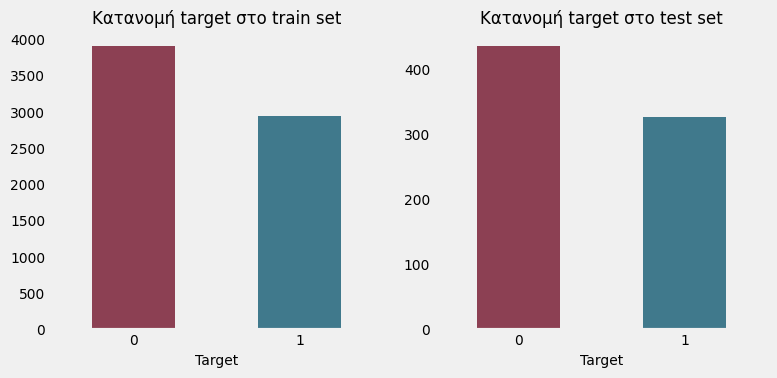

In [87]:
# δημιουργία bar plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

train_counts.plot(kind='bar', color=color_palette, ax=ax[0])
test_counts.plot(kind='bar', color=color_palette, ax=ax[1])

# ticks formatting
for a in ax:
    a.tick_params(axis='x', labelrotation=0, labelsize=10)
    a.tick_params(axis='y', labelsize=10)
    a.set_xlabel('Target', fontsize=10)
    a.grid(False)

ax[0].set_title('Κατανομή target στο train set', fontsize=12)
ax[1].set_title('Κατανομή target στο test set', fontsize=12)

plt.tight_layout()
plt.show()

**Σχολιασμός**

Το dataset εμφανίζει μια ελαφριά ανισορροπία (περισσότερα target=0 από target=1), ωστόσο δεν θεωρείται εξαιρετικά ασύμμετρο (imbalanced) ώστε να απαιτεί τεχνικές όπως το SMOTE. Παρόλα αυτά, θα χρησιμοποιήσουμε την μετρική F1-Score ως κριτήριο ως μετρική αξιολόγησης των αποτελεσμάτων, μιας και λαμβάνει υπόψιν τόσο το Precision όσο και το Recall.

### Ερώτημα 2: Data Preprocessing

In [88]:
# αφαίρεση id και location
train_df = train_df.drop(['id', 'location'], axis=1)
test_df = test_df.drop(['id', 'location'], axis=1)

# συμπλήρωση ελλιπών τιμών στο keyword
train_df['keyword'] = train_df['keyword'].fillna('null')
test_df['keyword'] = test_df['keyword'].fillna('null')

# ένωση keyword και text
train_df['inputs'] = train_df['keyword'] + ' ' + train_df['text']
test_df['inputs'] = test_df['keyword'] + ' ' + test_df['text']

### Ερώτημα 3: Αφαίρεση περιττών πληροφοριών

Θα εφαρμόσουμε τις τεχνικές που βασίζονται στο αποθετήριο
Deffro/text-preprocessing-techniques, επιλέγοντας τις παρακάτω:

1.  Remove URLs: Αφαίρεση συνδέσμων που δεν προσφέρουν σημασιολογική αξία στην ανίχνευση καταστροφής.
2.  Remove HTML tags: Καθαρισμός ετικετών που προκύπτουν από web scraping.
3.  Remove Unicode/Emojis: Αφαίρεση μη-ASCII χαρακτήρων για μείωση του θορύβου στα διανύσματα.
4.  Remove Punctuation: Αφαίρεση σημείων στίξης που αυξάνουν τη διάσταση του λεξιλογίου χωρίς λόγο.

**Αιτιολόγηση**

Επιλέχθηκαν αυτές οι τεχνικές για να μειωθεί η «αραιότητα» (sparsity) του πίνακα TF-IDF και να επικεντρωθεί το μοντέλο στις λέξεις-κλειδιά. Τις περνάμε σε μια συνάρτηση `clean_text`:

In [89]:
def clean_text(text):
    text = text.lower()
    # remove URLs
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # αφαίρεση σημείων στίξης
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [90]:
train_df['inputs'] = train_df['inputs'].apply(clean_text)
test_df['inputs'] = test_df['inputs'].apply(clean_text)

### Ερώτημα 4: Χωρίστε τα δεδομένα  σε inputs, targets (numpy arrays)

In [91]:
# μετατροπή σε Numpy Arrays
X_train_raw = train_df['inputs'].values
y_train = train_df['target'].values
X_test_raw = test_df['inputs'].values
y_test = test_df['target'].values

## Ερώτημα 5: Μετασχηματισμός TF-IDF

Για κάθε ανάρτηση (post), υπολογίστε το tf-idf κάθε λέξης. Χρησιμοποιήστε την κλάση TfIDFVectorizer της scikit-learn: https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html. Θα χρειαστεί να εφαρμόσετε fit_transform για το train set και σκέτο transform για το test set.

Η `tf-idf` (Term Frequency-Inverse Document Frequency) είναι μια μέθοδος που εξετάζει το πόσο συχνά εμφανίζεται μια λέξη σε μια συνολική ομάδα δεδομένων που προέρχονται από πολλές πηγές, για να καθορίσει τη σημασία μιας λέξης. Όσο πιο συχνά εμφανίζεται μια λέξη, τόσο χαμηλότερο είναι το βάρος που αντιστοιχεί σε αυτήν και τόσο λιγότερο σημαντική είναι σε ένα ενιαίο έγγραφο.

In [92]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

In [93]:
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")

TF-IDF features: 16711


## Ερώτημα 6: Εκπαίδευση LinearSVC

Εκπαιδεύστε ταξινομητή SVM με linear Kernel (LinearSVC)  https://scikit-learn.org/dev/modules/generated/sklearn.svm.LinearSVC.html στο train και μετρήστε για τα σύνολα train και test: Accuracy, F1, Precision, Recall.

In [94]:
# initialize
lsvc = LinearSVC(random_state=0)

# fit
lsvc.fit(X_train_tfidf, y_train)

# get predictions
y_pred_lsvc = lsvc.predict(X_test_tfidf)

# accuracy
svc_accuracy = accuracy_score(y_test, y_pred_lsvc)

# precision
svc_precision = precision_score(y_test, y_pred_lsvc)

# recall
svc_recall = recall_score(y_test, y_pred_lsvc)

# f1 score
svc_f1 = f1_score(y_test, y_pred_lsvc)

print(f"LinearSVC Accuracy: {svc_accuracy:.2f}")
print(f"LinearSVC Precision: {svc_precision:.2f}")
print(f"LinearSVC Recall: {svc_recall:.2f}")
print(f"LinearSVC F1 score: {svc_f1:.2f}")

LinearSVC Accuracy: 0.80
LinearSVC Precision: 0.79
LinearSVC Recall: 0.72
LinearSVC F1 score: 0.76


Βλέπουμε πως η ακρίβεια είναι ελαφρώς μεγαλύτερη από το F1, που είναι αναμενόμενο δεδομένης της μικρής ανισορροπίας στο dataset. Το πρόβλημα όμως εντοπίζεται στο Recall, καθώς μόνο 72% των True Positives εντοπίζεται και, όπως εξηγούμε παρακάτω, αυτό έχει το μεγαλύτερο κόστος και πρέπει να αποφευχθεί.

**Ποια μετρική είναι πιο σημαντική;**

Στο συγκεκριμένο project, η πιο σημαντική μετρική είναι το Recall, καθώς σε ένα σύστημα που συνδέεται με το 112, το κόστος ενός «False Negative» (να συμβαίνει καταστροφή και το σύστημα να μην την εντοπίσει) μπορεί να οδηγήσει σε απώλειες σε ανθρώπινες ζωές. Αντίθετα, ένα «False Positive» (λάθος συναγερμός) έχει μεν κόστος με την έννοια της απώλειας αξιοπιστίας προς το σύστημα ή κόστος για την άσκοπη κινητοποίση του πληθυσμού, είναι όμως πιο διαχειρίσιμο.

## Ερώτημα 7: Μετασχηματισμός PCA

Να εφαρμόσετε μετασχηματισμό PCA στα δεδομένα, κρατώντας το 95% της χρήσιμης πληροφορίας (προσοχή όχι των συνιστωσών!). Στη συνέχεια, να εκπαιδεύσετε τους LinearSVC και SVC με RBF kernel https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html και συγκρίνετε τις αποδόσεις τους.

In [95]:
# διατήρηση 95% της πληροφορίας
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [96]:
print(f"Number of components after PCA: {pca.n_components_}")

Number of components after PCA: 4174


In [97]:
# επανεκπαίδευση LinearSVC
lsvc_pca = LinearSVC(random_state=0)
lsvc_pca.fit(X_train_pca, y_train)
y_pred_lsvc_pca = lsvc_pca.predict(X_test_pca)

Και υπολογίζω εκ νέου τις μετρικές:

In [98]:
# accuracy
svc_pca_accuracy = accuracy_score(y_test, y_pred_lsvc_pca)

# precision
svc_pca_precision = precision_score(y_test, y_pred_lsvc_pca)

# recall
svc_pca_recall = recall_score(y_test, y_pred_lsvc_pca)

# f1 score
svc_pca_f1 = f1_score(y_test, y_pred_lsvc_pca)

In [99]:
print(f"LinearSVC Accuracy following PCA: {svc_pca_accuracy:.2f}")
print(f"LinearSVC Precision following PCA: {svc_pca_precision:.2f}")
print(f"LinearSVC Recall following PCA: {svc_pca_recall:.2f}")
print(f"LinearSVC F1 score following PCA: {svc_pca_f1:.2f}")

LinearSVC Accuracy following PCA: 0.81
LinearSVC Precision following PCA: 0.80
LinearSVC Recall following PCA: 0.74
LinearSVC F1 score following PCA: 0.77


Παρατηρώ πως έχω μια μικρή αύξηση του Recall (0.72 σε 0.74), και πάλι όμως δεν είναι ικανοποιητική.

Ας δοκιμάσουμε με την SVC, η οποία υποστηρίζει μη γραμμικά μοντέλα και kernels. Από τη θεωρία γνωρίζουμε πως η RBF (Radial Basis Function) διαχειρίζεται τα μη-γραμμικά διαχωρίσιμα σημεία ανάγοντάς τα σε υψηλότερες διαστάσεις. Έχει ως υπερπαράμετρο το gamma: εάν είναι μικρό, ελοχεύει ο κίνδυνος της υποπροσαρμογής, ενώ στην αντίθετη περίπτωση μπορεί να οδηγήσει σε υπερπροσαρμογή.

In [100]:
# επανεκπαίδευση SVC με RBF kernel
svc_rbf = SVC(kernel='rbf', random_state=0)
svc_rbf.fit(X_train_pca, y_train)
y_pred_rbf = svc_rbf.predict(X_test_pca)

Οι αντίστοιχες μετρικές είναι:

In [101]:
# accuracy
svc_rbf_accuracy = accuracy_score(y_test, y_pred_rbf)

# precision
svc_rbf_precision = precision_score(y_test, y_pred_rbf)

# recall
svc_rbf_recall = recall_score(y_test, y_pred_rbf)

# f1 score
svc_rbf_f1 = f1_score(y_test, y_pred_rbf)

In [102]:
print(f"SVC Accuracy using RBF: {svc_rbf_accuracy:.2f}")
print(f"SVC Precision using RBF: {svc_rbf_precision:.2f}")
print(f"SVC Recall using RBF: {svc_rbf_recall:.2f}")
print(f"SVC F1 score using RBF: {svc_rbf_f1:.2f}")

SVC Accuracy using RBF: 0.82
SVC Precision using RBF: 0.82
SVC Recall using RBF: 0.74
SVC F1 score using RBF: 0.77


Τα αποτελέσματα είναι παρόμοια με τη γραμμική SVC, χωρίς ιδιαίτερη βελτίωση.

### Ερώτημα 8: Ποια είναι η τιμή της παραμέτρου γ (Gamma)  που χρησιμοποιείται ως default ‘scale’ και ποια η τιμή ‘auto’; Να αλλάξετε την παράμετρο γ σε ‘auto’ και να επανεκπαιδεύστε τον SVC. Τέλος, να δημιουργήσετε bar-plot, συγκρίνοντας τις μετρικές  accuracy, F1, precision, recall των τεσσάρων μοντέλων που εκπαιδεύτηκαν.

Από το documentation της SCV έχουμε για την gamma:
- Όταν έχει τιμή `scale` ο τύπος είναι `1 / (n_features * X.var())`, δηλαδή είναι αντιστρόφως ανάλογη της διακύμανσης των δεδομένων.
- Όταν έχει τιμή  `auto` ο τύπος είναι `1 / n_features`, δηλαδή χρησιμοποιεί μόνο το πλήθος των χαρακτηριστικών.

Επομένως επανεκπαιδεύω τον SVC θέτοντας την gamma ως `auto`:

In [ ]:
svc_rbf_auto = SVC(kernel='rbf', gamma='auto', random_state=0)
svc_rbf_auto.fit(X_train_pca, y_train)
y_pred_rbf_auto = svc_rbf_auto.predict(X_test_pca)

In [104]:
# accuracy
svc_rbf_auto_accuracy = accuracy_score(y_test, y_pred_rbf_auto)

# precision
svc_rbf_auto_precision = precision_score(y_test, y_pred_rbf_auto)

# recall
svc_rbf_auto_recall = recall_score(y_test, y_pred_rbf_auto)

# f1 score
svc_rbf_auto_f1 = f1_score(y_test, y_pred_rbf_auto)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [105]:
print(f"SVC Accuracy using RBF with gamma set to 'auto': {svc_rbf_auto_accuracy:.2f}")
print(f"SVC Precision using RBF with gamma set to 'auto': {svc_rbf_auto_precision:.2f}")
print(f"SVC Recall using RBF with gamma set to 'auto': {svc_rbf_auto_recall:.2f}")
print(f"SVC F1 score using RBF with gamma set to 'auto': {svc_rbf_auto_f1:.2f}")

SVC Accuracy using RBF with gamma set to 'auto': 0.57
SVC Precision using RBF with gamma set to 'auto': 0.00
SVC Recall using RBF with gamma set to 'auto': 0.00
SVC F1 score using RBF with gamma set to 'auto': 0.00


**Σχολιασμός**

Το μοντέλο με `gamma = 'auto'` δεν κατάφερε να δώσει αποτελέσματα για την κλάση 0, και αυτό προκύπτει από τις μηδενικές τιμές για ευστοχία, ανάκληση και F1. Ο λόγος φαίνεται πως είναι πως το πηλίκο για τον υπολογισμό της `gamma` = 1 / 4174 είναι πολύ μικρό (~0.00024), το οποίο δεν επιτρέπει στο μοντέλο να εκπαιδευτεί και να μάθει από τα δεδομένα.

Ας δούμε και το bar plot:

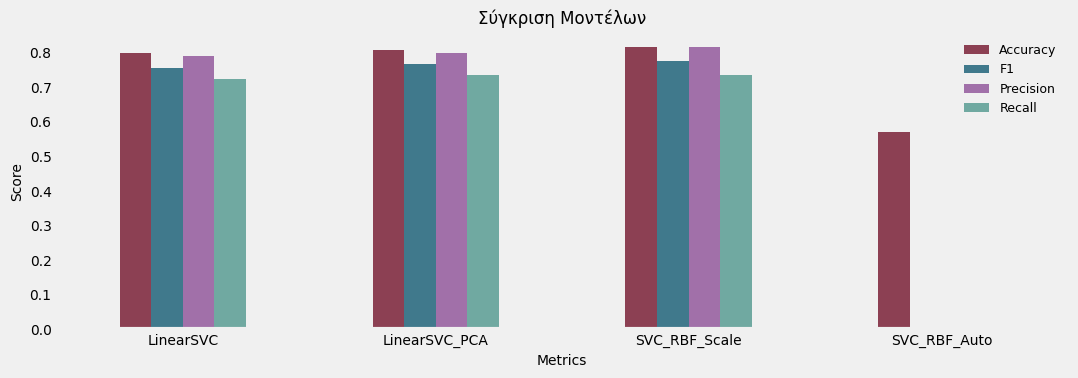

In [106]:
ax = res_df.plot(kind='bar', figsize=(11, 4), color=color_palette)

plt.title('Σύγκριση Μοντέλων', fontsize=12)
plt.ylabel('Score', fontsize=10)
plt.xlabel('Metrics', fontsize=10)

# ticks formatting
ax.tick_params(axis='x', labelrotation=0, labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# remove grid
ax.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend
plt.legend(loc='upper right', fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

### Ερώτημα 9: Να επαναλάβετε την ερώτηση 6 (πριν εφαρμοστεί ο μετασχηματισμός PCA) με τη χρήση Gaussian Naive Bayes: https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [ ]:
# initialize
gnb = GaussianNB()

# το GaussianNB απαιτεί πυκνό πίνακα (dense array)
gnb.fit(X_train_tfidf.toarray(), y_train)
y_pred_gnb = gnb.predict(X_test_tfidf.toarray())

In [108]:
# accuracy
linear_svc_gnb_accuracy = accuracy_score(y_test, y_pred_gnb)

# precision
linear_svc_gnb_precision = precision_score(y_test, y_pred_gnb)

# recall
linear_svc_gnb_recall = recall_score(y_test, y_pred_gnb)

# f1 score
linear_svc_gnb_f1 = f1_score(y_test, y_pred_gnb)

In [109]:
print(f"SVC Accuracy using Gaussian Naive Bayes: {linear_svc_gnb_accuracy:.2f}")
print(f"SVC Precision using Gaussian Naive Bayes: {linear_svc_gnb_precision:.2f}")
print(f"SVC Recall using Gaussian Naive Bayes: {linear_svc_gnb_recall:.2f}")
print(f"SVC F1 score using Gaussian Naive Bayes: {linear_svc_gnb_f1:.2f}")

SVC Accuracy using Gaussian Naive Bayes: 0.63
SVC Precision using Gaussian Naive Bayes: 0.55
SVC Recall using Gaussian Naive Bayes: 0.79
SVC F1 score using Gaussian Naive Bayes: 0.65


Το αποτέλεσμα δείχνει πως με τη χρήση του Gaussian Naive Bayes έχω το καλύτερο αποτέλεσμα στο Recall, που ήταν ο στόχος μου. Έχω όμως πολύ χαμηλό σκορ στην ευστοχία (55%) που σημαίνει πως σχεδόν 1 στις 2 ειδοποιήσεις καταστροφής είναι λανθασμένη!

Συμπερασματικά, δεν έχουμε καταφέρει να έχουμε ένα μοντέλο το οποίο να είναι αξιόπιστο στην πρόβλεψη φυσικών καταστροφών, και δεν θα το προτείναμε ως υλοποίηση.